In [1]:
# Load pickled data
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
#from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
### Load the images and plot them here.
import os
from sklearn.utils import shuffle
# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
#training_file = '/Volumes/SSD/traffic-signs-data/train.p' # change it to your local dir
#testing_file = '/Volumes/SSD/traffic-signs-data/test.p' # change it to your local dir
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    validation = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_validation,y_validation = validation['features'],validation['labels']
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset？
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


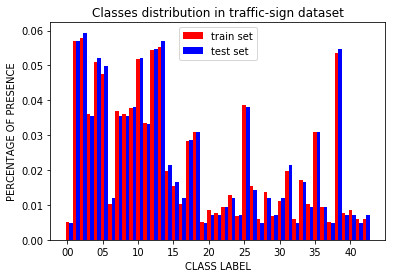

In [3]:
# bar chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5) )
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

In [4]:
def preprocess_features(X, equalize_hist=True):
    # Convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(img), 2) for img in X])

    X = np.float32(X)

    # Standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train_norm = preprocess_features(X_train)
X_validation_norm = preprocess_features(X_validation)
X_test_norm = preprocess_features(X_test)


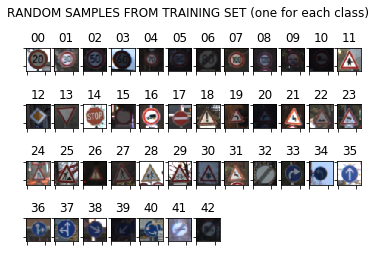

In [5]:
# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols) # ax_array is a array object consistint of plt object
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)

plt.draw()

In [6]:
n_classes = 43
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

In [7]:

def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)

def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val,shape=shape)
    return tf.Variable(initialization)

def conv2d(x, W, strides=[1,1,1,1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)

def max_pool2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# network architecture definition
def my_net(x, n_classes):

    c1_out = 32
    conv1_W = weight_variable(shape=(5,5,1,c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
#    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)
    conv1 = tf.nn.relu(tf.add(conv2d(x, conv1_W) , conv1_b))
    pool1 = max_pool2x2(conv1)

    #drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    c2_out = 64
    conv2_W = weight_variable(shape=(5,5,c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(pool1, conv2_W) + conv2_b)

    pool2 = max_pool2x2(conv2)

    #drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

    #fc0 = tf.concat([flatten(pool1), flatten(pool2)],1 )
    fc0 = flatten(pool2)
    fc1_out = 128
    fc1_W = weight_variable(shape=(fc0.shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1_l = tf.add(tf.matmul(fc0, fc1_W),fc1_b)
    
    fc1 = tf.nn.relu(fc1_l)
    
    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    fc2_out = 128
    fc2_W = weight_variable(shape=(drop_fc1.shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    fc2_l = tf.add(tf.matmul(drop_fc1, fc2_W),fc2_b)
    
    fc2 = tf.nn.relu(fc2_l)
    
    drop_fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)
    
    
    fc3_out = n_classes
    fc3_W = weight_variable(shape=(drop_fc2.shape[1].value, fc3_out))
    fc3_b = bias_variable(shape=(fc3_out,))
    logits = tf.matmul(drop_fc2, fc3_W) + fc3_b

    return logits

tf.reset_default_graph()
# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32,1))
y = tf.placeholder(dtype=tf.int64, shape=None)
keep_prob = tf.placeholder(tf.float32)

# training pipeline
lr = 0.0009
logits = my_net(x, n_classes=n_classes)
#logits = LeNet(x)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss=loss_function)

correct_prediction = tf.equal(tf.argmax(logits, 1), y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [8]:
EPOCHS = 60
BATCHES_PER_EPOCH = 3
BATCH_SIZE = 128

In [9]:
## Split validation dataset off from training dataset


X_train, X_validation, y_train, y_validation = train_test_split(X_train_norm, y_train, test_size=0.20, random_state=42)
#X_train = X_train_norm
#X_validation = X_validation_norm
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for epoch in range(EPOCHS):
        batch_counter = 0
        X_train,y_train = shuffle(X_train,y_train)
        for offset in range(0,num_examples,BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x,batch_y = X_train[offset:end],y_train[offset:end]
            sess.run(training_operation,feed_dict = {x:batch_x,y:batch_y,keep_prob:0.5})
        
        
        
#       for batch_x, batch_y in image_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
#           batch_counter += 1
#           sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
#
#          if batch_counter == BATCHES_PER_EPOCH:
#             break
        # at epoch end, evaluate accuracy on both training and validation set
        train_accuracy = evaluate(X_train, y_train)
        #X_validation,y_validation = shuffle(X_validation, y_validation)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(epoch+1))
        print("Training Accuracy = {:.3f}, Validation Accuracy = {:.3f}".format(train_accuracy, validation_accuracy))
        print()
    saver.save(sess, save_path='./checkpoints/traffic_sign_model.ckpt')#, global_step=epoch

KeyboardInterrupt: 

In [ ]:
# Now (drumroll) evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('C://./Users/13120/Desktop/无人驾驶工程师第二个项目/CarND-Traffic-Sign-Classifier-Project-master/checkpoints/traffic_sign_model.ckpt.meta')
    print('sdfsdfsddcheshi')
    saver2.restore(sess, 'C://./Users/13120/Desktop/无人驾驶工程师第二个项目/CarND-Traffic-Sign-Classifier-Project-master/checkpoints/' + '.\\' + 'traffic_sign_model.ckpt')
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))